# Data Cleaning 3: outliers

## <br>By Jean-Philippe Pitteloud</br>

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
%matplotlib inline

warnings.filterwarnings('ignore')

### Data Gathering

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

edu_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing 
engine.dispose()

In [3]:
edu_df.tail()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
1487,2017_VIRGINIA,VIRGINIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,248.041059,290.081407,227.598382,273.402640
1488,2017_WASHINGTON,WASHINGTON,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,241.701001,289.131257,223.123409,267.744778
1489,2017_WEST_VIRGINIA,WEST_VIRGINIA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,236.057019,273.415854,217.316396,271.617023
1490,2017_WISCONSIN,WISCONSIN,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.389213,288.143144,219.612694,258.700304
1491,2017_WYOMING,WYOMING,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.820619,288.761812,226.831211,269.371456


In [4]:
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

### Data Cleaning

In [5]:
edu_df_cleaned = edu_df.copy()

In [6]:
edu_df_cleaned.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'],
      dtype='object')

In [7]:
edu_df_cleaned.drop(['PRIMARY_KEY', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'], axis = 1, inplace = True)

In [8]:
edu_df_cleaned['YEAR'].nunique()

26

In [9]:
edu_df_cleaned['STATE'].nunique()

80

In [10]:
edu_df_cleaned['STATE'] = edu_df_cleaned['STATE'].str.replace('_-_', '_')

edu_df_cleaned['bureau'] = edu_df_cleaned['STATE'].str.contains('^[B][UREAU]{5}\w+|^[B][I][E]?', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['bureau'], 'BUREAU_OF_INDIAN_EDUCATION', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('bureau', axis = 1, inplace = True)

edu_df_cleaned['maria'] = edu_df_cleaned['STATE'].str.contains('NORTHERN_MARIANAS|COMMONWEALTH_OF_MARIANAS|MARIANAS|^[M][P]$', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['maria'], 'NORTHERN_MARIANA_ISLANDS', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('maria', axis = 1, inplace = True)

edu_df_cleaned['dod'] = edu_df_cleaned['STATE'].str.contains('DEPARTMENT|DOD|DD', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['dod'], 'DEPARTMENT_OF_DEFENSE', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('dod', axis = 1, inplace = True)

edu_df_cleaned['as'] = edu_df_cleaned['STATE'].str.contains('AMERICAN_SAMOA|^[A][S]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['as'], 'AMERICAN_SAMOA', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('as', axis = 1, inplace = True)

edu_df_cleaned['guam'] = edu_df_cleaned['STATE'].str.contains('GUAM|^[G][U]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['guam'], 'GUAM', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('guam', axis = 1, inplace = True)

edu_df_cleaned['pr'] = edu_df_cleaned['STATE'].str.contains('PUERTO_RICO|^[P][R]', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['pr'], 'PUERTO_RICO', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('pr', axis = 1, inplace = True)

edu_df_cleaned['vi'] = edu_df_cleaned['STATE'].str.contains('VIRGIN_ISLANDS|^[V][I]$', case = False, regex = True)
edu_df_cleaned['STATE'] = np.where(edu_df_cleaned['vi'], 'VIRGIN_ISLANDS', edu_df_cleaned['STATE'])
edu_df_cleaned.drop('vi', axis = 1, inplace = True)

In [11]:
edu_df_cleaned['STATE'].nunique()

58

In [12]:
null_df = edu_df_cleaned.copy()
null_df.set_index(['YEAR', 'STATE'], inplace = True)

In [13]:
null_df = null_df.isnull()

In [14]:
null_df.reset_index(inplace = True)

In [15]:
null_df.groupby(['STATE']).sum()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G
STATE,,,,,,,,,,,,,,,,,,,
ALABAMA,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
ALASKA,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
AMERICAN_SAMOA,46070,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
ARIZONA,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
ARKANSAS,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
BUREAU_OF_INDIAN_EDUCATION,30090,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,8.0,7.0,7.0,7.0,7.0,7.0,15.0
CALIFORNIA,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
COLORADO,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
CONNECTICUT,52117,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [16]:
edu_df_cleaned.columns

Index(['STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE',
       'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE',
       'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
       'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G',
       'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G',
       'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G'],
      dtype='object')

In [17]:
columns = ['ENROLL', 'TOTAL_REVENUE', 'FEDERAL_REVENUE',
       'STATE_REVENUE', 'LOCAL_REVENUE', 'TOTAL_EXPENDITURE',
       'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
       'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G',
       'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G',
       'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G'] 

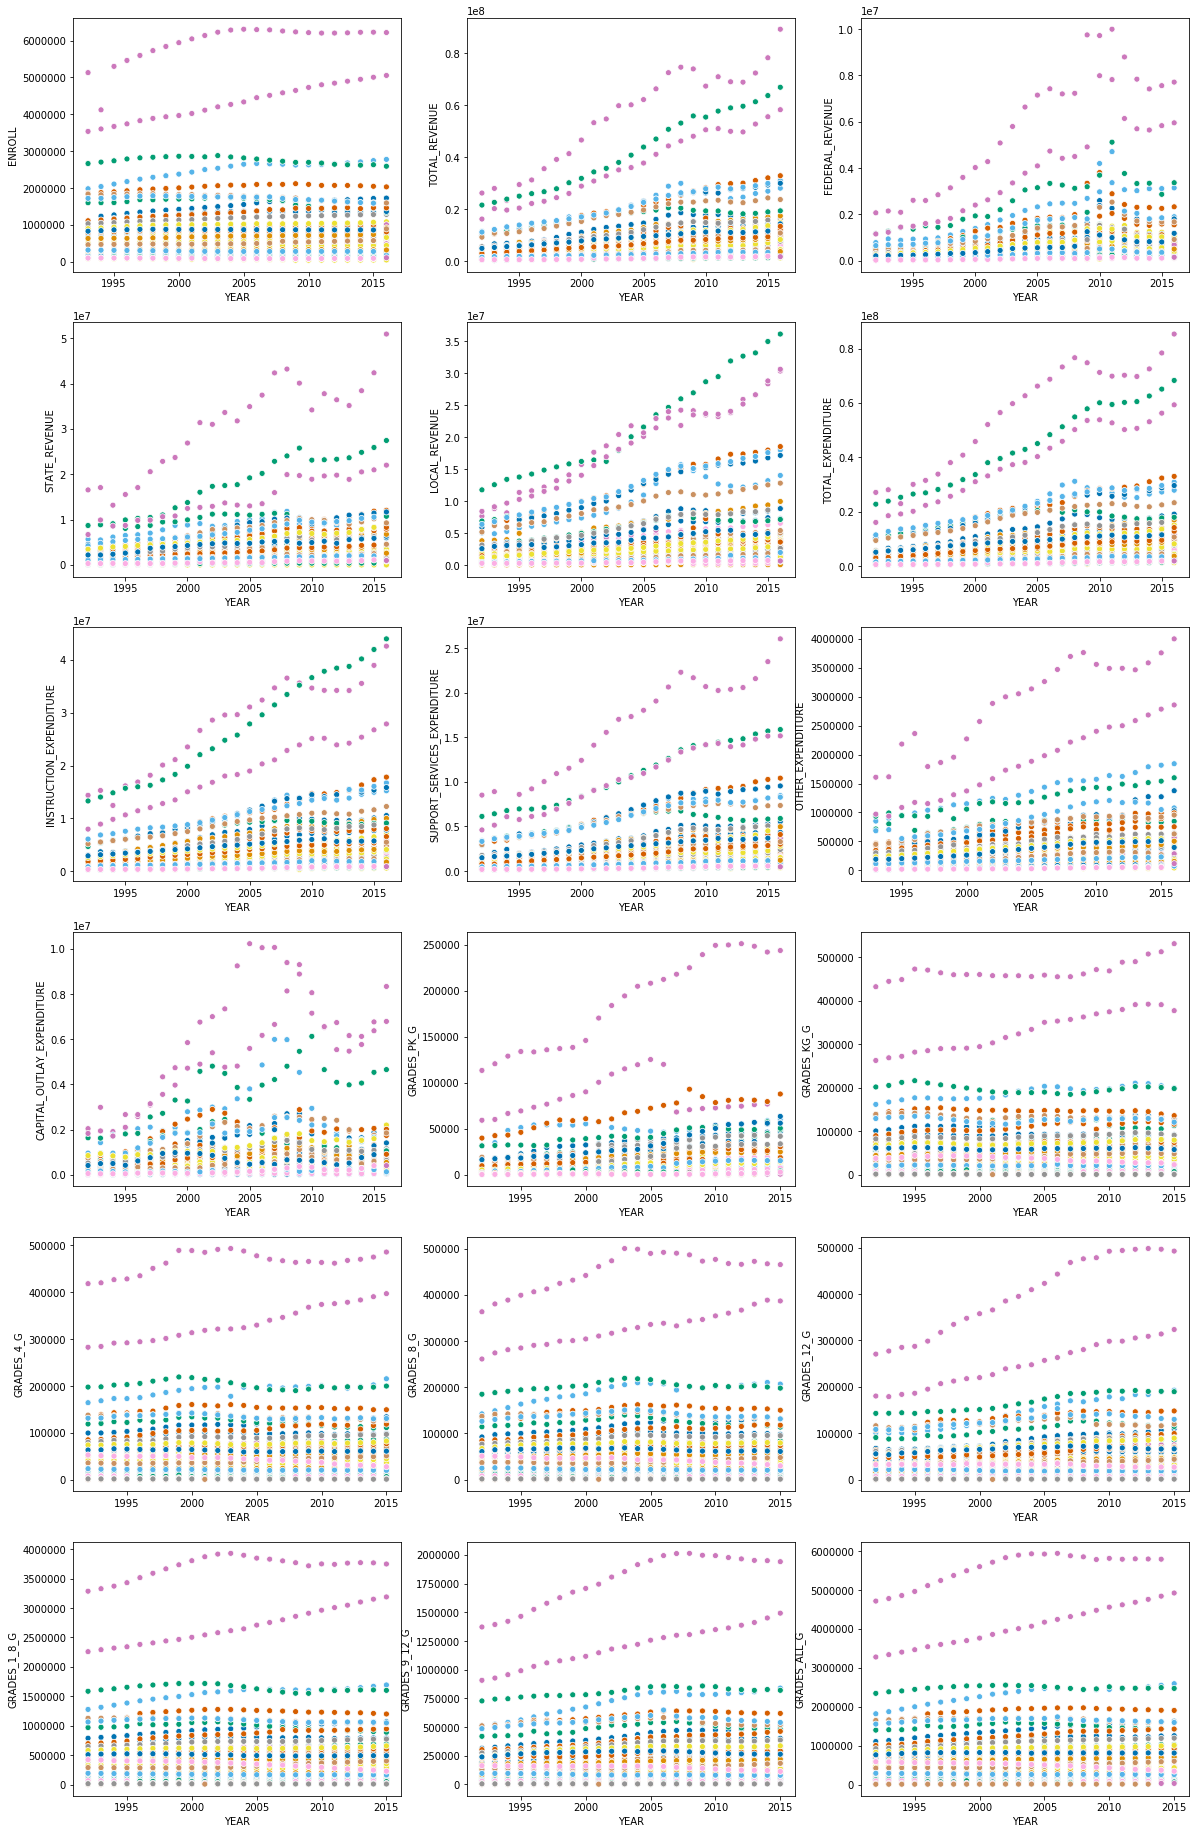

In [18]:
fig = plt.figure(figsize=(20,100))

for i, column in enumerate(columns):
    plt.subplot(len(columns), 3, i+1)
    sns.scatterplot(data = edu_df_cleaned, x = 'YEAR', y = column, hue = 'STATE', legend = False, palette = 'colorblind');

In [19]:
edu_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 20 columns):
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1361 non-null float64
GRADES_12_G                     

In [20]:
states = edu_df_cleaned['STATE'].unique()

In [21]:
for state in states:
    edu_df_cleaned.loc[edu_df_cleaned['STATE'] == state, columns] = edu_df_cleaned.loc[edu_df_cleaned["STATE"] == state, columns].interpolate()

In [22]:
edu_df_cleaned.dropna(inplace=True)

In [23]:
edu_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 52 to 1491
Data columns (total 20 columns):
STATE                           1274 non-null object
YEAR                            1274 non-null int64
ENROLL                          1274 non-null float64
TOTAL_REVENUE                   1274 non-null float64
FEDERAL_REVENUE                 1274 non-null float64
STATE_REVENUE                   1274 non-null float64
LOCAL_REVENUE                   1274 non-null float64
TOTAL_EXPENDITURE               1274 non-null float64
INSTRUCTION_EXPENDITURE         1274 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1274 non-null float64
OTHER_EXPENDITURE               1274 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1274 non-null float64
GRADES_PK_G                     1274 non-null float64
GRADES_KG_G                     1274 non-null float64
GRADES_4_G                      1274 non-null float64
GRADES_8_G                      1274 non-null float64
GRADES_12_G                    

**1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?**

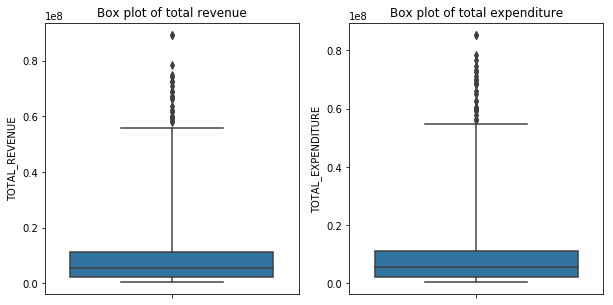

In [24]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot(edu_df_cleaned["TOTAL_REVENUE"], whis = 5, orient = 'v')
plt.title("Box plot of total revenue")

plt.subplot(1,2,2)
sns.boxplot(edu_df_cleaned["TOTAL_EXPENDITURE"], whis = 5, orient = 'v')
plt.title("Box plot of total expenditure");

From the box plots above, we can conclude that both variables, ' TOTAL_REVENUE' and 'TOTAL_EXPENDITURE' have a considerable number of potential outliers

**2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values afterwards you handled them**

In order to address the presence of outliers in the variables of interest, a method called "winsorization" will be used. Two new variables derived from the originals will be created named 'winsorized_revenue' and 'winsorized_expenditure'

In [35]:
winsorized_revenue = winsorize(edu_df_cleaned["TOTAL_REVENUE"], (0.05, 0.05))

winsorized_expenditure = winsorize(edu_df_cleaned["TOTAL_EXPENDITURE"], (0.05, 0.05))

To confirm the success in addressing the potential outliers, the following plots were created. 

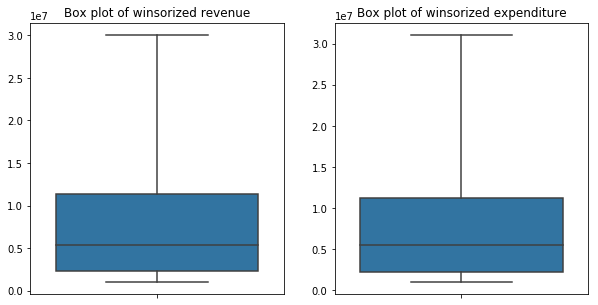

In [36]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot(winsorized_revenue, whis = 5, orient = 'v')
plt.title("Box plot of winsorized revenue")

plt.subplot(1,2,2)
sns.boxplot(winsorized_expenditure, whis = 5, orient = 'v')
plt.title("Box plot of winsorized expenditure");

As it can be seen in the plots above, the winsorization method successfully addressed the presence of potential outliers in both variables of interest

**3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable**

In [27]:
budget_deficit = edu_df_cleaned['TOTAL_REVENUE'] - edu_df_cleaned['TOTAL_EXPENDITURE']

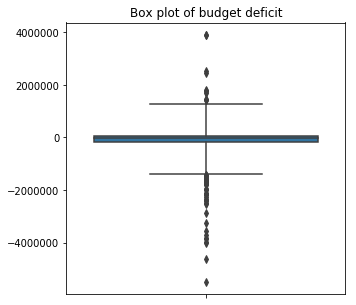

In [28]:
plt.figure(figsize = (5,5))
sns.boxplot(budget_deficit, whis = 5, orient = 'v')
plt.title("Box plot of budget deficit");

In the box plot displayed above, a number of potential outliers can be confirmed on both the positive and negative ends. In an attempt to remove these potential outliers from the data, a winsorization approach was employed and a box plot of the resulting data displayed below

In [29]:
winsorized_deficit = winsorize(budget_deficit, (0.05, 0.05))

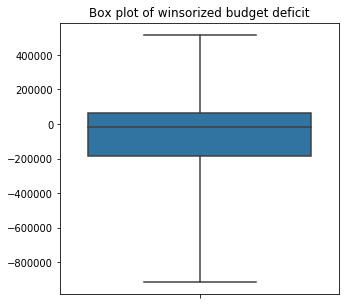

In [30]:
plt.figure(figsize = (5,5))
sns.boxplot(winsorized_deficit, whis = 5, orient = 'v')
plt.title("Box plot of winsorized budget deficit");

As it can be seen in the plot above, winsorization of the new variable 'winsorized_deficit' effectively removed any outlier present in the variable

**4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. But this time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them**

In [31]:
budget_deficit_2 = winsorized_revenue - winsorized_expenditure

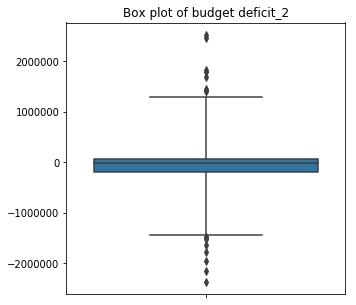

In [32]:
plt.figure(figsize = (5,5))
sns.boxplot(budget_deficit_2, whis = 5, orient = 'v')
plt.title("Box plot of budget deficit_2");

In the plot above, it can be concluded that the use of the previously winsorized variables to calculate the 'budget deficit' variable resulted in a dataset with potential outliers on both ends. The use of winsorization to address their presence was evaluated and the results highlighted below

In [33]:
winsorized_deficit_2 = winsorize(budget_deficit_2, (0.05, 0.05))

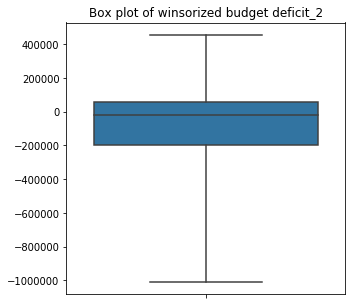

In [34]:
plt.figure(figsize = (5,5))
sns.boxplot(winsorized_deficit_2, whis = 5, orient = 'v')
plt.title("Box plot of winsorized budget deficit_2");

Once again, the plot above suggest that the use of winsorization effectively removed the potential outliers seen in the untreated dataset

**5. Compare some basic statistics of the budget variables you end up with in the third and the fourth questions. Do you see any differences?**

In [37]:
pd.DataFrame({"original_deficit": budget_deficit, "winsorized_deficit_1": winsorized_deficit,
              "winsorized_deficit_2": winsorized_deficit_2}).describe()

,original_deficit,winsorized_deficit_1,winsorized_deficit_2
count,1.274000e+03,1274.000000,1.274000e+03
mean,-9.666534e+04,-71856.539246,-9.784575e+04
std,5.902863e+05,315356.514146,3.415663e+05
min,-5.487742e+06,-913765.000000,-1.010049e+06
25%,-1.833178e+05,-183317.750000,-1.959658e+05
50%,-1.890700e+04,-18907.000000,-2.217650e+04
75%,6.306000e+04,63060.000000,5.735700e+04
max,3.897129e+06,516023.000000,4.563530e+05


From the summary statistics shown above, it seems that the second approach (use of winsorized variables and later winsorization of the resulting difference) more successfully preserve the values of central tendency with comparable values for the mean. As expected, the removal of extreme values in both approaches resulted in a reduction of the spread in the data reflected by smaller values of standard deviation (std). Same argunment applies to any difference witnessed in the values of minumum (min) and maximum (max)

**6. If our variable of interest is the budget deficit variable, which method do you think is the most appropriate one in dealing with the outliers in this variable. The method in the third question or the one in the fourth question?**

Based on the results at hand, both approaches seem to sucessfully remove potential outliers in the dataset, however, the summary statistics suggest that the use of double winsorization (at the individual variable level and then at the calculated level) generates a dataset with more similar statistics than the untreated dataset. However, I believe the use of data in its raw state to construct new features shoudl be preferred in order to preserve the biggest amount of original data